In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time
import os, warnings

import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications import VGG16
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#The path of our data on drive
data_dir =  r'/content/drive/MyDrive/X-Ray Image DataSet'

#Loading Data
data = load_files(data_dir)

In [ ]:
folders=os.listdir("/content/drive/MyDrive/X-Ray Image DataSet")
print(folders)

['Covid-19', 'No_findings']


In [ ]:
#Convert the data and labels to Numpy arrays
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])

# How the arrays look like
print('Data files - ',X[0])
print('Target labels - ',y[0])
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Data files -  /content/drive/MyDrive/X-Ray Image DataSet/No_findings/00003384_000.png
Target labels -  1
Number of training files :  635
Number of training targets :  635


In [ ]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 224,224
    # Loop over the image paths
    for file_path in file_path_list:
        """
           Load the image, swap color channels, and resize it to be a fixed
           224*224 pixels while ignoring aspect ratio
        """
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)

        # update the data
        arr.append(img)
    return arr
# Here our data is updated and it's stocked in the X array again !
X = np.array(convert_img_to_arr(X))

# The Data Shape
print(X.shape)
print('First training item : ',X[0])

(635, 224, 224, 3)
First training item :  [[[  4.   4.   4.]
  [  4.   4.   4.]
  [  4.   4.   4.]
  ...
  [  7.   7.   7.]
  [ 10.  10.  10.]
  [ 13.  13.  13.]]

 [[  4.   4.   4.]
  [  4.   4.   4.]
  [  4.   4.   4.]
  ...
  [  7.   7.   7.]
  [  9.   9.   9.]
  [ 13.  13.  13.]]

 [[  4.   4.   4.]
  [  4.   4.   4.]
  [  4.   4.   4.]
  ...
  [  7.   7.   7.]
  [  9.   9.   9.]
  [ 12.  12.  12.]]

 ...

 [[230. 230. 230.]
  [231. 231. 231.]
  [234. 234. 234.]
  ...
  [221. 221. 221.]
  [226. 226. 226.]
  [228. 228. 228.]]

 [[232. 232. 232.]
  [233. 233. 233.]
  [234. 234. 234.]
  ...
  [223. 223. 223.]
  [226. 226. 226.]
  [229. 229. 229.]]

 [[234. 234. 234.]
  [236. 236. 236.]
  [236. 236. 236.]
  ...
  [224. 224. 224.]
  [227. 227. 227.]
  [230. 230. 230.]]]


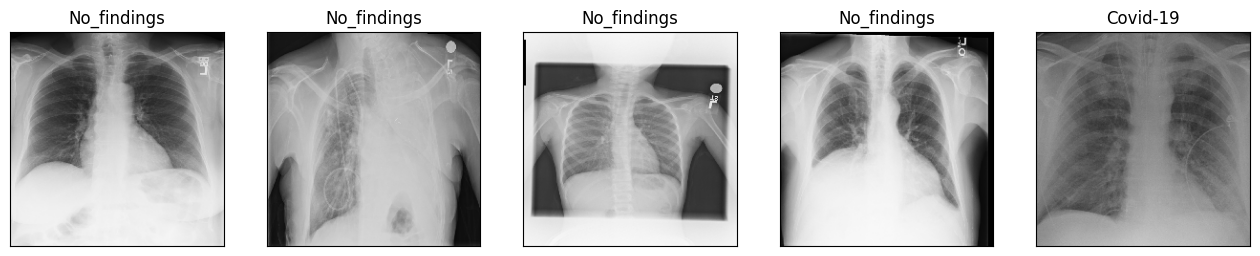

In [ ]:
# Let's look at first 5 training data.
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

In [ ]:
"""
   After that data is converted into Numpy array, Now,
   Let's scale the pixel intenties to the range[0,255]
"""
X = X.astype('float32')/255

# Let's confirm the number of classes :)
no_of_classes = len(np.unique(y))
no_of_classes

2

In [ ]:
y

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,

In [ ]:
"""
let's converts a class vector (integers) to binary class matrix by performing the
one-hot encoding on the labels
"""
y = np.array(to_categorical(y,no_of_classes))
y[0]

array([0., 1.], dtype=float32)

In [ ]:
# let's splite the data into subsets and explore their shapes !

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])

X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The train Data Shape  508
The validation Data Shape  64
The test Data Shape  63


In [ ]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (224, 224, 3)


In [ ]:
# load the VGG16 model without the final layers(include_top=False)
baseModel = VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])
print("Base Model loaded !")

"""
  Loop over all layers in the base model and freeze them so they will
  not be updated during the first training process
"""
for layer in baseModel.layers:
    layer.trainable = False

baseModel.summary()

58889256/58889256 [==============================] - 0s 0us/step
Base Model loaded !
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                          

In [ ]:
# In the summary above of our base model, trainable params is 0
""" Now, let's create a headModel to put on top of the base model
    (we are not freezing any layers of this model)
"""
headModel = Sequential()
headModel.add(AveragePooling2D(pool_size=(4,4), input_shape=baseModel.output_shape[1:], name="AveragePooling2"))
headModel.add(Flatten( name ="Flatten"))
headModel.add(Dense(64, activation ="relu"))
headModel.add(Dropout(0.5, name="Dropout"))
headModel.add(Dense(no_of_classes, activation="softmax"))

headModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AveragePooling2 (AveragePo  (None, 1, 1, 512)         0         
 oling2D)                                                        
                                                                 
 Flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 Dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 32962 (128.76 KB)
Trainable params: 32962 (128.76 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
# In the summary above of our base model, trainable params is 32, 962
""" Let's build the final model where we add the top_model on top of base_model.
    So, we will place the head Model on the top of the base Model. Therefore, this
    'Model' will become the actual model we will train
"""
Model = Sequential()
Model.add(baseModel)
Model.add(headModel)

# I can check the summary of the final Model which we created by using the line of code below.
Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 sequential (Sequential)     (None, 2)                 32962     
                                                                 
Total params: 14747650 (56.26 MB)
Trainable params: 32962 (128.76 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
lr = 1e-3
epochs = 50
bs = 8
optimizer = Adam(learning_rate = lr)
Model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
 #Time to train our model !
epochs = 100

# Initialize the training data augmentation object
train_datagen = ImageDataGenerator(
        rotation_range=15,
        fill_mode ="nearest")

checkpointer = ModelCheckpoint(filepath = "/drive/My Drive/CDX_Best.h5", save_best_only = True, verbose=1)
start = time.time()

# let's get started !

history=Model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),
                            steps_per_epoch = len(X_train)//bs,
                            validation_data = (X_valid, y_valid),
                            validation_steps = len(X_valid)//bs,
                            epochs =epochs,
                            callbacks= [checkpointer])

end = time.time()
duration = end - start
print ('\n This Model took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )


<ipython-input-17-bf9c57aed30a>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=Model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),


Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 0.5382 - accuracy: 0.7800
Epoch 1: val_loss improved from inf to 0.40391, saving model to /drive/My Drive/CDX_Best.h5
63/63 [==============================] - 23s 154ms/step - loss: 0.5382 - accuracy: 0.7800 - val_loss: 0.4039 - val_accuracy: 0.8594


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 0.4532 - accuracy: 0.7920
Epoch 2: val_loss improved from 0.40391 to 0.38815, saving model to /drive/My Drive/CDX_Best.h5
63/63 [==============================] - 9s 143ms/step - loss: 0.4532 - accuracy: 0.7920 - val_loss: 0.3881 - val_accuracy: 0.8594
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 0.4110 - accuracy: 0.8060
Epoch 3: val_loss improved from 0.38815 to 0.31576, saving model to /drive/My Drive/CDX_Best.h5
63/63 [==============================] - 6s 100ms/step - loss: 0.4110 - accuracy: 0.8060 - val_loss: 0.3158 - val_accuracy: 0.8750
Epoch 4/100
63/63 [==============================] - ETA: 0s - loss: 0.3790 - accuracy: 0.8340
Epoch 4: val_loss improved from 0.31576 to 0.29044, saving model to /drive/My Drive/CDX_Best.h5
63/63 [==============================] - 9s 136ms/step - loss: 0.3790 - accuracy: 0.8340 - val_loss: 0.2904 - val_accuracy: 0.8906
Epoch 5/100
63/63 [===============

In [ ]:
(eval_loss, eval_accuracy) = Model.evaluate(
     X_test, y_test, batch_size=bs, verbose=2)

print("Accuracy: {:.2f}%".format(eval_accuracy * 100))
print("Loss: {}".format(eval_loss))

8/8 - 2s - loss: 0.0401 - accuracy: 0.9841 - 2s/epoch - 203ms/step
Accuracy: 98.41%
Loss: 0.04010889679193497


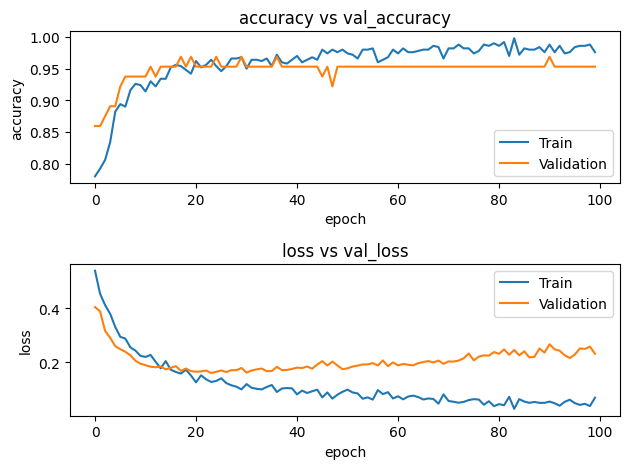

In [ ]:
import matplotlib.pyplot as plt
def plot(history):
    plt.figure(1)
     # Summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy vs val_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

     # Summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss vs val_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()

# Finaly, let's call the plot function with the 'result' parameter

plot(history)


2/2 [==============================] - 7s 3s/step


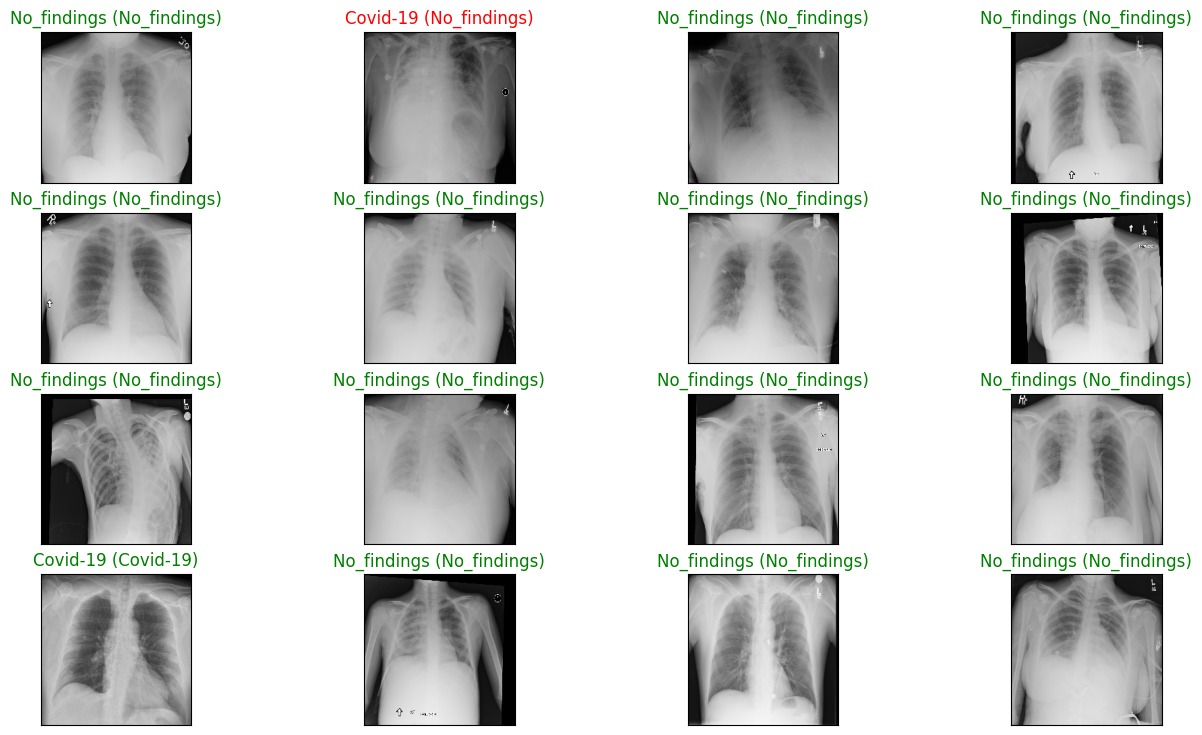

In [ ]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# Plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(Model.predict(X_test))

2/2 [==============================] - 0s 117ms/step


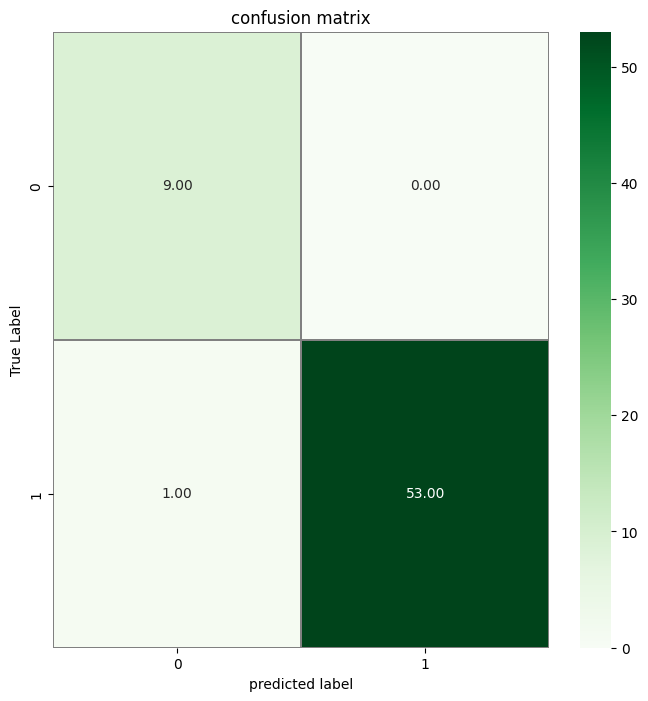

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = Model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test.argmax(axis=1),Y_pred_classes,  target_names= labels))

              precision    recall  f1-score   support

    Covid-19       0.90      1.00      0.95         9
 No_findings       1.00      0.98      0.99        54

    accuracy                           0.98        63
   macro avg       0.95      0.99      0.97        63
weighted avg       0.99      0.98      0.98        63



In [ ]:
my_model=keras.models.load_model('/drive/My Drive/CDX_Best.h5')

2/2 [==============================] - 0s 120ms/step


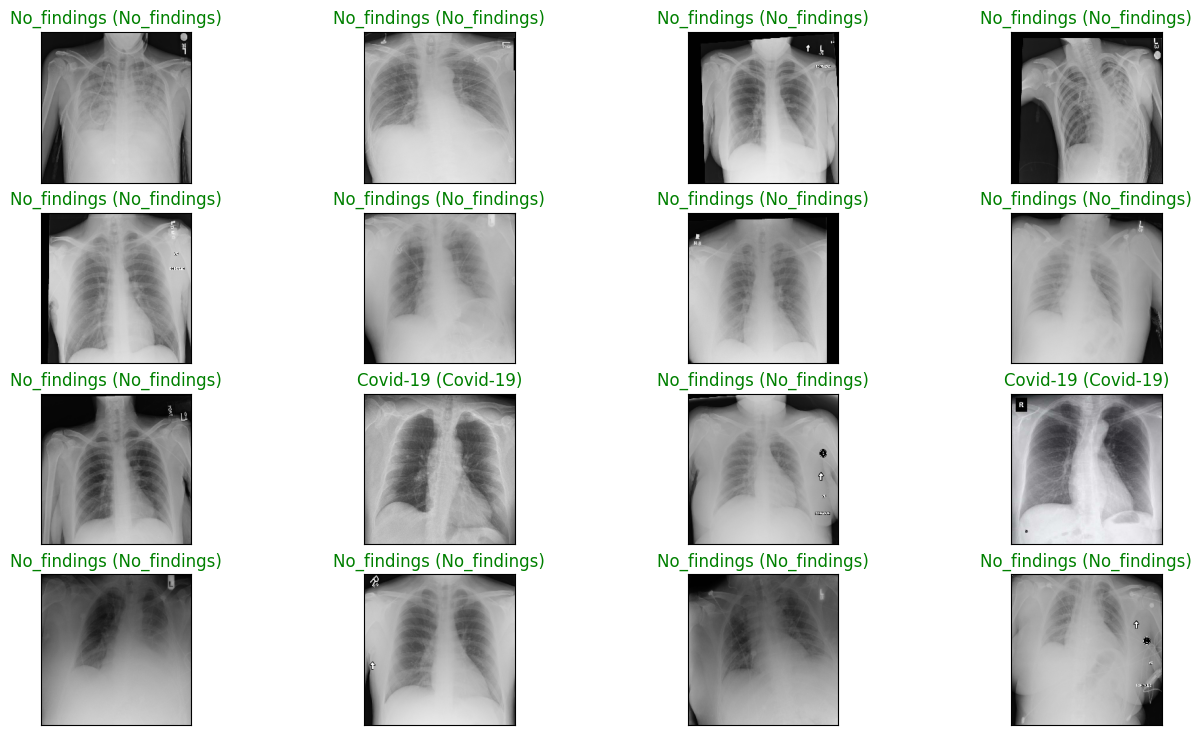

In [ ]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(my_model.predict(X_test))

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=27b37e4bbf5dc7bafba2dc88ccc663960c30075ae79e6d0ccead3395dfc460b1
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Predicted Class: Covid19 Positive, Probability: 1.0


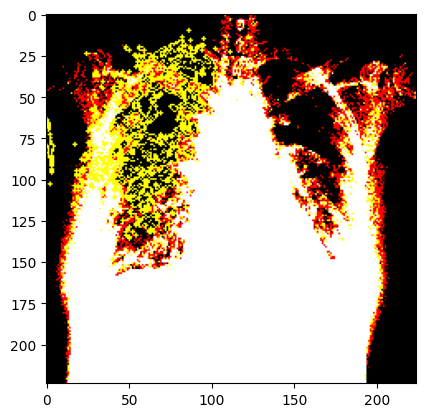

In [ ]:
import numpy as np
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import keras

# Load your prediction model
my_model = keras.models.load_model('/drive/My Drive/CDX_Best.h5')

# Load an image for which you want to generate explanations
img_path = '/content/drive/MyDrive/X-Ray Image DataSet/Covid-19/1-s2.0-S0929664620300449-gr2_lrg-c.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Get the predicted class and probability from your model
predicted_class = np.argmax(my_model.predict(x), axis=1)
predicted_probability = np.max(my_model.predict(x), axis=1)

# Map class indices to class names
class_mapping = {1: "Covid19 Negative",0: "Covid19 Positive"}
predicted_class_name = class_mapping[predicted_class[0]]


# Use LIME for image explanation
explainer = lime_image.LimeImageExplainer()

# Function to predict with your model (preprocess input according to model requirements)
def predict_function(images):
    return my_model.predict(preprocess_input(images))

# Explain predictions on the image
explanation = explainer.explain_instance(x[0], predict_function, top_labels=5, hide_color=0, num_samples=1000)

# Show the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

# Print the predicted class and probability
print(f'Predicted Class: {predicted_class_name}, Probability: {predicted_probability[0]}')
plt.show()


In [ ]:
!pip install tabulate


In [ ]:
# Import necessary libraries
import numpy as np
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from lime import lime_image
from tabulate import tabulate

# Load a pre-trained CNN model (VGG16 in this example)
model = VGG16(weights='imagenet')
# Modify the model to work with LIME
model.predict(np.random.rand(1, 224, 224, 3))  # Ensure the model is built

# Load an image for which you want to generate explanations
img_path = '/content/drive/MyDrive/X-Ray Image DataSet/Covid-19/1-s2.0-S0929664620300449-gr2_lrg-c.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Get the predicted class and probability from your model
predicted_class = np.argmax(my_model.predict(x), axis=1)
predicted_probability = np.max(my_model.predict(x), axis=1)

# Map class indices to class names
class_mapping = {1: "Covid19 Negative",0: "Covid19 Positive"}
predicted_class_name = class_mapping[predicted_class[0]]



# Use LIME for image explanation
explainer = lime_image.LimeImageExplainer()

# Function to predict with the model (preprocess input according to model requirements)
def predict_function(images):
    return model.predict(preprocess_input(images))

# Explain predictions on the image
explanation = explainer.explain_instance(x[0], predict_function, top_labels=5, hide_color=0, num_samples=1000)

# Tabular explanation (using tabulate for formatting)
top_features = explanation.local_exp[explanation.top_labels[0]]
features_table = [["Feature Index", "Weight"]] + top_features


# Print the predicted class and probability
print(f'Predicted Class: {predicted_class_name}, Probability: {predicted_probability[0]}')

# Show the explanation in a table
print("Tabular Explanation:")
print(tabulate(features_table, headers="firstrow", tablefmt="pretty"))


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step
Predicted Class: Covid19 Positive, Probability: 1.0
Tabular Explanation:
+---------------+------------------------+
| Feature Index |         Weight         |
+---------------+------------------------+
|      44       |  0.004542697150193738  |
|      55       |  0.004351885245149722  |
|      131      |  0.004287947426278407  |
|      11       |  0.00412258761854285   |
|      35       |  0.004009540019283198  |
|      105      |  0.003921226870734582  |
|      119      | 0.0036858832635299254  |
|      51       | 0.0036708081239532632  |
|      144      |  0.003646155919736778  |
|      82       | 0.0036381339100725403  |
|      19       | 0.0035316433319170057  |
|      115      |  0.00348010707649265   |
|      21       |  0.00343198852783023   |
|      107      | 0.0034206981439719487  |
|      136      | 0.0034086579560015018  |
|      87       | 0.0034068477886649066  |
|      33       | 0.0033490361065626117  |
|      99      